## Árvores de regressão - exercícios 02

Este exercício será uma continuação do anterior, mesma base, mesmas variáveis - vamos tentar buscar a 'melhor árvore'.

A descrição das variáveis está abaixo:

| Variavel | Descrição|
|-|-|
|CRIM| taxa de crimes per-cápita da cidade | 
|ZN| proporção de terrenos residenciais zoneados para lotes com mais de 25.000 pés quadrados. |
|INDUS| proporção de acres de negócios não varejistas por cidade |
|CHAS |vale 1 se o terreno faz fronteira com o *Charles River*; 0 caso contrário |
|NOX| Concentração de óxido nítrico (em partes por 10 milhões) |
|RM| número médio de quartos por habitação |
|AGE| proporção de unidades ocupadas pelo proprietário construídas antes de 1940 |
|DIS| distâncias ponderadas até cinco centros de empregos de Boston |
|RAD| índice de acessibilidade a rodovias radiais |
|TAX| taxa de imposto sobre a propriedade de valor total por \\$10,000 |
|PTRATIO| razão pupilo-professor da cidade |
|B| $ 1000 (Bk - 0,63) ^ 2 $ onde Bk é a proporção de negros por cidade |
|LSTAT| \%status inferior da população |
|MEDV| (variável resposta) Valor mediano das casas ocupadas pelo proprietário em US $ 1.000|

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz

from IPython.display import Image

from sklearn.tree import export_text
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
#boston = datasets.load_boston()
#X = pd.DataFrame(boston.data, columns = boston.feature_names)
#y = pd.DataFrame(boston.target, columns = ['MEDV'])

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = pd.DataFrame(np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]]), 
                 columns=[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX','PTRATIO', 'B','LSTAT']])
y = pd.DataFrame(raw_df.values[1::2, 2], columns=['MEDV'])

In [3]:
# por reforçar preconceitos a variável B será excluída das análises
# também vamos remorar a variável 'CHAS' pois, apesar de ser um numéro ela é categórica
X.drop(columns=['B', 'CHAS'], inplace=True, axis=1, level=0)

In [4]:
X.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03
3,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94
4,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33


In [5]:
y.head()

,MEDV
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


### 1. Execute os passos do exercício anterior, até que você tenha uma árvore de regressão predizendo o valor do imóvel na base de treinamento.

In [6]:
# Dados em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

# Criando e treinando o modelo da árvore de regressão
modelo_arvore = DecisionTreeRegressor()
modelo_arvore.fit(X_treino, y_treino)

# Fazendo previsões no conjunto de teste
predicoes = modelo_arvore.predict(X_teste)

# Calculando o Mean Squared Error (MSE)
mse = mean_squared_error(y_teste, predicoes)
print('Mean Squared Error (MSE):', mse)

Mean Squared Error (MSE): 10.489705882352942


### 2.  Calcule o caminho indicado pelos CCP-alfas dessa árvore.

In [7]:
path = modelo_arvore.cost_complexity_pruning_path(X_treino, y_treino)

Text(0, 0.5, 'Impureza total das folhas')

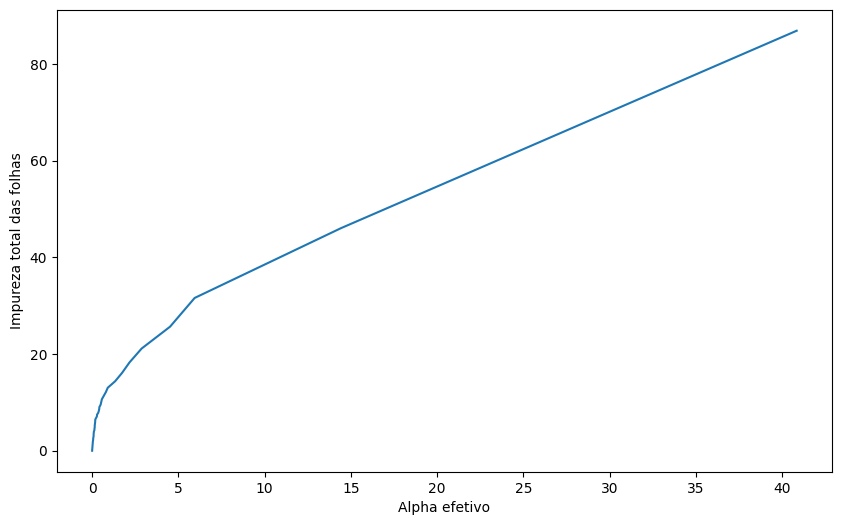

In [8]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("Alpha efetivo")
plt.ylabel("Impureza total das folhas")

### 3. Paca cada valor de alpha obtido no item 2, treine uma árvore com o respectivo alfa, e guarde essa árvore em uma lista.

In [9]:
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_treino, y_treino)
    clfs.append(clf)

Text(0, 0.5, 'Profundidade da árvore')

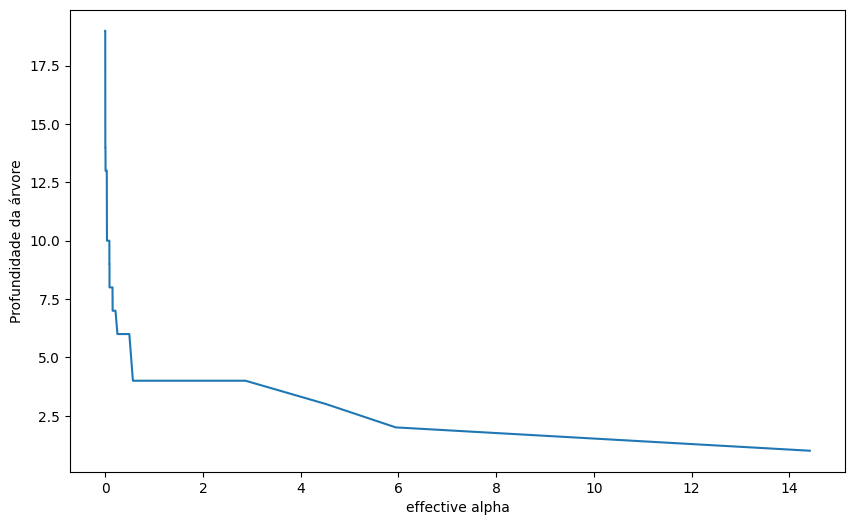

In [10]:
tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Profundidade da árvore")

### 4. Para cada árvore na lista, calcule o MSE da árvore.

In [11]:
train_scores = [mean_squared_error(y_treino, clf.predict(X_treino)) for clf in clfs]
test_scores  = [mean_squared_error(y_teste, clf.predict(X_teste )) for clf in clfs]

### 5. Monte um gráfico do MSE pelo alpha, escolha um valor de alpha perto do ponto de mínimo do MSE¶

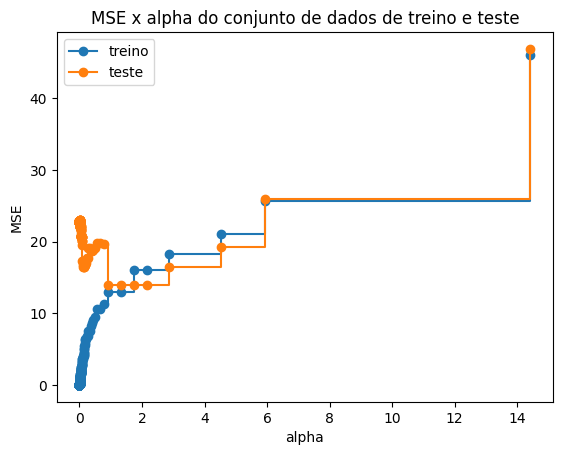

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("MSE x alpha do conjunto de dados de treino e teste")
ax.plot(ccp_alphas[:-1], train_scores[:-1], marker='o', label="treino",
        drawstyle="steps-post")
ax.plot(ccp_alphas[:-1], test_scores[:-1], marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

Escolhemos o ccp_alpha de 1.5

In [13]:
# Para alpha de 1.5
arvore_ccp = DecisionTreeRegressor(random_state=0, ccp_alpha=1.5)
arvore_ccp.fit(X_treino, y_treino)

DecisionTreeRegressor(ccp_alpha=1.5, random_state=0)

In [14]:
print(f"MSE para alpha = 1.5: {mean_squared_error(y_teste, arvore_ccp.predict(X_teste))}")

MSE para alpha = 1.5: 14.209458204590593


### 6. Calcule o R-quadrado dessa árvore encontrada no item acima

In [15]:
print(f"R² para alpha = 1.5: {arvore_ccp.score(X_teste, y_teste)}")

R² para alpha = 1.5: 0.806235849396645


### 7. Visualize esta árvore.

In [16]:
dot_data = export_text(arvore_ccp, feature_names=list(X.columns))
print(dot_data)

|--- ['RM'] <= 6.94
|   |--- ['LSTAT'] <= 14.40
|   |   |--- ['DIS'] <= 1.38
|   |   |   |--- value: [44.48]
|   |   |--- ['DIS'] >  1.38
|   |   |   |--- ['RM'] <= 6.54
|   |   |   |   |--- value: [21.63]
|   |   |   |--- ['RM'] >  6.54
|   |   |   |   |--- value: [27.50]
|   |--- ['LSTAT'] >  14.40
|   |   |--- ['CRIM'] <= 6.93
|   |   |   |--- value: [17.06]
|   |   |--- ['CRIM'] >  6.93
|   |   |   |--- value: [11.90]
|--- ['RM'] >  6.94
|   |--- ['RM'] <= 7.44
|   |   |--- ['LSTAT'] <= 15.76
|   |   |   |--- value: [33.30]
|   |   |--- ['LSTAT'] >  15.76
|   |   |   |--- value: [14.10]
|   |--- ['RM'] >  7.44
|   |   |--- value: [44.65]



In [17]:
# Criando um gráfico
dot_data = tree.export_graphviz(arvore_ccp, 
                                out_file=None, 
                                feature_names=list(X.columns),  
                                filled=True, 
                                rounded=True, 
                                special_characters=True)  

graph = graphviz.Source(dot_data, format='png', filename='arvore')  
graph.view()

'arvore.png'

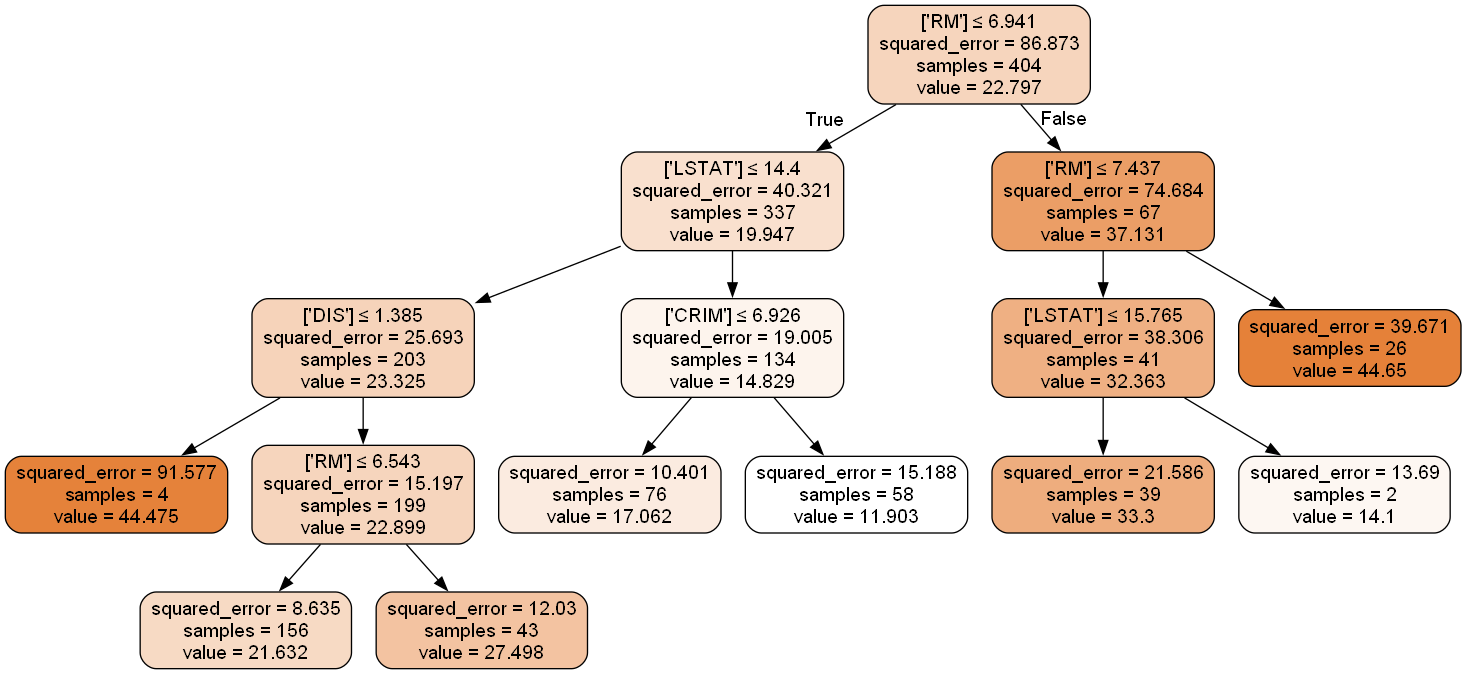

In [18]:
Image(filename='arvore.png')